In [69]:
import networkx as nx
import random
import itertools as it

# networkx DiGraph representations of the drawn motifs in motifs.txt.
motifs = {
  "m1": nx.DiGraph([(1,2),(1,3)]),
  "m2": nx.DiGraph([(2,1),(3,1)]),
  "m3": nx.DiGraph([(1,2),(2,3)]),
  "m4": nx.DiGraph([(1,2),(2,3),(3,2)]),
  "m5": nx.DiGraph([(1,2),(1,3),(3,1)]),
  "m6": nx.DiGraph([(1,2),(2,1),(1,3),(3,1)]),
  "m7": nx.DiGraph([(1,2),(1,3),(2,3)]),
  "m8": nx.DiGraph([(1,2),(2,3),(3,1)]),
  "m9": nx.DiGraph([(2,1),(3,1),(2,3),(3,2)]),
  "m10": nx.DiGraph([(1,2),(1,3),(2,3),(3,2)]),
  "m11": nx.DiGraph([(1,2),(2,3),(3,2),(3,1)]),
  "m12": nx.DiGraph([(1,2),(2,1),(1,3),(3,1),(2,3)]),
  "m13": nx.DiGraph([(1,2),(2,1),(1,3),(3,1),(2,3),(3,2)]),
}

In [70]:
# Get input graph.
def get_graph():
  try:
    # Get input graph.
    with open(input('Provide path to graph file: '), 'r') as input_graph:
      G = nx.read_weighted_edgelist(input_graph, create_using=nx.DiGraph, nodetype = int)
    input_graph.close()
    
    return G
  except FileNotFoundError:
    print("FileNotFoundError: Invalid file or directory. Check the file exists and try again.")

# Get motif of interest.
def get_motif():
  motifs = open('motifs.txt', 'r')
  motif_prompt = motifs.read()
  
  chosen_motif = input(
    motif_prompt + "\n" +
    "Choose one motif listed above (1 - 13) of which you'll change its frequency: "
  )
  while not chosen_motif.isnumeric() or int(chosen_motif) < 1 or int(chosen_motif) > 13:
    chosen_motif = input(
      motif_prompt + "\n" + "Please enter a number between 1 and 13: "
    )
  
  motifs.close()
  
  return f"m{chosen_motif}"

# Get frequency change (increasing or decreasing).
def get_freq_change():
  freq = input("Increase or decrease frequency of motif? (i or d): ")
  while freq != "i" and freq != "d":
    freq = input("Please enter i or d: ")
    
  return freq

In [71]:
# Calculate frequency of specified motif in a subgraph of G induced 
# by the specified neighborhood.
def motif_freq(G, motif, neighborhood):
  motif = motifs[motif]
  triads = it.combinations(neighborhood, 3)

  freq = 0
  for tri in triads:
    subgraph = nx.subgraph(G, tri)
    if nx.is_isomorphic(subgraph, motif):
      freq += 1
  
  return freq

In [72]:
# Select two random edges from a given edge list.
def random_edges(edges):
  u = random.choice(edges)
  v = random.choice(edges)
  
  # Ensure u and v do not share nodes.
  while u[0] in v or u[1] in v:
    v = random.choice(edges)
  
  return u, v

def get_neighborhood(G, u, v):
  u0_neighbors = list(G.successors(u[0])) + list(G.predecessors(u[0]))
  u1_neighbors = list(G.successors(u[1])) + list(G.predecessors(u[1]))
  v0_neighbors = list(G.successors(v[0])) + list(G.predecessors(v[0]))
  v1_neighbors = list(G.successors(v[1])) + list(G.predecessors(v[1]))
  
  neighborgood = set(u0_neighbors + u1_neighbors + v0_neighbors + v1_neighbors)
  
  return neighborgood

def undo_swap(G, u, v):
  G.remove_edge(u[0], v[1])
  G.remove_edge(v[0], u[1])
  
  G.add_edge(u[0], u[1])
  G.add_edge(v[0], v[1])
  
  return G

# Swap two edges in graph G.
def swap_edges(G, motif, freq_change):
  edges = list(G.edges)
  u, v = random_edges(edges)

  # Prevent multi-edge
  while G.has_edge(u[0], v[1]) or G.has_edge(v[0], u[1]):
    u, v = random_edges(edges)
    
  neighborhood_before_swap = get_neighborhood(G, u, v)
  mf_before_swap = motif_freq(G, motif, neighborhood_before_swap)

  G.remove_edge(u[0], u[1])
  G.remove_edge(v[0], v[1])
  
  G.add_edge(u[0], v[1])
  G.add_edge(v[0], u[1])
  
  neighborhood_after_swap = get_neighborhood(G, u, v)
  mf_after_swap = motif_freq(G, motif, neighborhood_after_swap)
  
  # Discard edge swap if motif frequency does not change as desired.
  if (freq_change == "i" and mf_after_swap < mf_before_swap) \
    or (freq_change == "d" and mf_after_swap > mf_before_swap):
    G = undo_swap(G, u, v)
  
  return G


# Randomize graph G using biased link randomization, maintaining degree sequence.
def randomize(G, motif, freq_change):
  steps = 10 * G.number_of_edges()
  for _ in range(steps):
    G = swap_edges(G, motif, freq_change)
  
  return G

In [73]:
# Return the degree sequence of graph G.
def degree_sequence(G):
  return [d for _, d in G.degree()]

In [74]:
def main():
  G, motif, freq_change = get_graph(), get_motif(), get_freq_change()
  r_G = randomize(G, motif, freq_change)
  
  print(degree_sequence(G) == degree_sequence(r_G))
  print(motif_freq(G, motif, list(G.nodes)), motif_freq(r_G, motif, list(G.nodes)))
  
  # TODO: After randomization, compare the number of occurrences of the motif in the 
  # original network with the number of occurrences in the randomized one:
  #   - if there are significantly more of the given motif in the original network, 
  #     we can say that it is "over expressed",
  #   - if there are significantly less of the given motif in the original network, 
  #     we can say that it is "under expressed".
  # More details in slides.
  
  # TODO: Characteristics of interest: changing of network parameters such as the
  # average clustering coefficient, assortativity coefficient, average shortest
  # path length, etc., during the randomization.

True
0 0


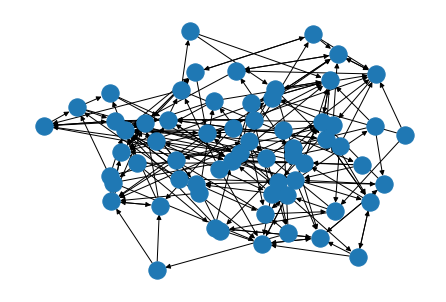

In [75]:
if __name__ == '__main__':
  main()